In [1225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


In [1226]:
df = pd.read_excel("Worksheet in Case Study question 2.xlsx")

df.head()


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [1227]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   months_as_customer           1000 non-null   int64         
 1   age                          1000 non-null   int64         
 2   policy_number                1000 non-null   int64         
 3   policy_bind_date             1000 non-null   datetime64[ns]
 4   policy_state                 1000 non-null   object        
 5   policy_csl                   1000 non-null   object        
 6   policy_deductable            1000 non-null   int64         
 7   policy_annual_premium        1000 non-null   float64       
 8   umbrella_limit               1000 non-null   int64         
 9   insured_zip                  1000 non-null   int64         
 10  insured_sex                  1000 non-null   object        
 11  insured_education_level      1000 non-null  

In [1228]:
df


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16,OH,500/1000,1000,1310.80,0,431289,...,1,?,87200,17440,8720,61040,Honda,Accord,2006,N
996,285,41,186934,2014-01-05,IL,100/300,1000,1436.79,0,608177,...,3,?,108480,18080,18080,72320,Volkswagen,Passat,2015,N
997,130,34,918516,2003-02-17,OH,250/500,500,1383.49,3000000,442797,...,3,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N
998,458,62,533940,2011-11-18,IL,500/1000,2000,1356.92,5000000,441714,...,1,YES,46980,5220,5220,36540,Audi,A5,1998,N


# EDA

In [1229]:
df.columns


Index(['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_state', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital-gains', 'capital-loss',
       'incident_date', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported'],
      dtype='object')

In [1230]:
df['policy_number'].duplicated().sum()  # ดูว่ามีค่าซ้ำไหม


0

In [1231]:
df[df["fraud_reported"] == "N"]["total_claim_amount"].mean()


50288.605577689246

In [1232]:
df[df["fraud_reported"] == "Y"]["total_claim_amount"].mean()


60302.10526315789

In [1233]:
fig = px.histogram(df, x="total_claim_amount", color='fraud_reported')
fig.show()


In [1234]:
fig = px.histogram(df, x="incident_hour_of_the_day", color='fraud_reported')
fig.show()


In [1235]:
fig = px.histogram(df, x="injury_claim", color='fraud_reported')
fig.show()


In [1236]:
fig = px.histogram(df, x="months_as_customer", color='fraud_reported')
fig.show()


In [1237]:
fig = px.histogram(df, x="policy_annual_premium", color='fraud_reported')
fig.show()


In [1238]:
fig = px.histogram(df, x="bodily_injuries", color='fraud_reported')
fig.show()


In [1239]:
df_analysis = df.copy()
# สร้างกลุ่มอายุ
# สร้างกลุ่มอายุ
bins = [0, 19, 29, 39, 49, 59, 69, 79, 100]
labels = ['<20', '20–29', '30–39', '40–49', '50–59', '60–69', '70–79', '80+']
df_analysis['age_group'] = pd.cut(
    df_analysis['age'], bins=bins, labels=labels, right=True)

# สร้างตารางสรุป fraud กับ non-fraud ในแต่ละกลุ่มอายุ
summary = df_analysis.groupby(
    ['age_group', 'fraud_reported']).size().reset_index(name='count')

# แปลงค่าความหมายของ is_fraud เป็นข้อความ
summary['fraud_status'] = summary['fraud_reported'].map(
    {"N": 'Non-Fraud', "Y": 'Fraud'})
summary['total'] = summary.groupby('age_group')['count'].transform('sum')
summary['percent'] = (summary['count'] / summary['total'] * 100).round(2)

# สร้างกราฟ stacked bar
fig = px.bar(summary, x='age_group', y='count', color='fraud_status',
             title='จำนวน Fraud และ Non-Fraud แยกตามช่วงอายุ',
             labels={'age_group': 'ช่วงอายุ', 'count': 'จำนวน',
                     'fraud_status': 'สถานะ', 'percent': "เปอร์เซ็นต์"},
             barmode='stack',
             hover_data={'percent': True, 'count': True,
                         'fraud_status': True, 'age_group': True}
             )
fig.show()


/var/folders/qc/wbl1sccd3yn5ndpj0nb5bp7w0000gn/T/ipykernel_3815/674156307.py:10: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/qc/wbl1sccd3yn5ndpj0nb5bp7w0000gn/T/ipykernel_3815/674156307.py:16: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [1240]:
import pandas as pd
import plotly.express as px

df_analysis = df.copy()

# 🔹 กำหนดช่วง (bins) และ labels สำหรับ months_as_customer
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, float('inf')]
labels = [
    '0–49', '50–99', '100–149', '150–199', '200–249', '250–299',
    '300–349', '350–399', '400–449', '450–499', '500+'
]

# 🔹 สร้างกลุ่มตามช่วง months_as_customer
df_analysis['months_group'] = pd.cut(
    df_analysis['months_as_customer'], bins=bins, labels=labels, right=False)

# 🔹 สร้างตารางสรุป
summary = df_analysis.groupby(['months_group', 'fraud_reported']).size().reset_index(name='count')
summary['fraud_status'] = summary['fraud_reported'].map({"Y": 'Non-Fraud', "N": 'Fraud'})
summary['total'] = summary.groupby('months_group')['count'].transform('sum')
summary['percent'] = (summary['count'] / summary['total'] * 100).round(2)

# 🔹 สร้าง stacked bar chart
fig = px.bar(
    summary,
    x='months_group', y='count', color='fraud_status',
    title='จำนวน Fraud และ Non-Fraud แยกตามช่วงเวลาที่เป็นลูกค้า (Months)',
    labels={
        'months_group': 'ช่วง Months as Customer',
        'count': 'จำนวน',
        'fraud_status': 'สถานะ Fraud',
        'percent': "เปอร์เซ็นต์"
    },
    barmode='stack',
    hover_data={'percent': True, 'count': True, 'fraud_status': True, 'months_group': True}
)

fig.show()

/var/folders/qc/wbl1sccd3yn5ndpj0nb5bp7w0000gn/T/ipykernel_3815/3949240561.py:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/qc/wbl1sccd3yn5ndpj0nb5bp7w0000gn/T/ipykernel_3815/3949240561.py:20: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [1241]:
df_N = df[df["fraud_reported"] == "N"]


In [1242]:
df_Y = df[df["fraud_reported"] == "Y"]
df_Y


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
5,256,39,104594,2006-10-12,OH,250/500,1000,1351.10,0,478456,...,2,NO,64100,6410,6410,51280,Saab,95,2003,Y
14,180,38,644081,1998-12-28,OH,250/500,2000,1301.13,0,476685,...,2,YES,46200,4200,8400,33600,Dodge,Neon,2003,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974,234,41,291006,1990-05-16,IN,100/300,500,951.56,0,455426,...,1,?,98280,15120,7560,75600,Chevrolet,Tahoe,2007,Y
977,266,42,929306,2003-03-06,IN,100/300,500,1093.83,4000000,468454,...,1,NO,53280,4440,8880,39960,Suburu,Impreza,2015,Y
982,230,43,490514,2007-02-09,IN,500/1000,2000,1101.83,0,451529,...,3,YES,51900,5190,10380,36330,BMW,M5,2011,Y
986,232,42,182953,2013-04-30,IN,100/300,500,944.03,0,440153,...,3,?,77000,15400,7700,53900,Toyota,Highlander,2015,Y


In [1243]:
# คำนวณจำนวน fraud และ total ต่อ state
fraud_summary = df.groupby('incident_state')[
    'fraud_reported'].value_counts().unstack().fillna(0)
fraud_summary['total'] = fraud_summary.sum(axis=1)
fraud_summary['fraud_percent'] = (
    fraud_summary['Y'] / fraud_summary['total'] * 100).round(2)
fraud_summary['total_fraud'] = fraud_summary['Y']

# สร้าง DataFrame สรุป
state_fraud_percent = fraud_summary.reset_index(
)[['incident_state', 'fraud_percent', 'total', 'total_fraud']]
state_fraud_percent


fraud_reported,incident_state,fraud_percent,total,total_fraud
0,NC,30.91,110,34
1,NY,22.14,262,58
2,OH,43.48,23,10
3,PA,26.67,30,8
4,SC,29.44,248,73
5,VA,22.73,110,25
6,WV,17.97,217,39


In [1244]:
fig = px.choropleth(state_fraud_percent,
                    locations='incident_state',         # รหัสรัฐ เช่น 'NY', 'PA'
                    locationmode='USA-states',
                    color='fraud_percent',              # ใช้ % แทน count
                    color_continuous_scale='Reds',
                    scope='usa',
                    labels={'fraud_percent': '% Fraud'},
                    title='Fraud % by Incident State',
                    hover_data={'incident_state': True, 'fraud_percent': True, 'total': True, 'total_fraud': True})
fig.show()


In [1245]:
# เลือกเฉพาะคอลัมน์ที่เป็น int
df_int = df.select_dtypes(include='int')

# คำนวณ correlation
corr_matrix = df_int.corr()

# แสดงผล


fig = px.imshow(corr_matrix,
                text_auto=True,
                title="Correlation Matrix of Integer Columns",
                color_continuous_scale='RdBu_r',
                zmin=-1, zmax=1)
fig.show()


# EDA func isnull

In [1246]:
df = pd.read_excel("Worksheet in Case Study question 2.xlsx", dtype=str)

df.head()


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17 00:00:00,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27 00:00:00,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06 00:00:00,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25 00:00:00,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06 00:00:00,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [1247]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   months_as_customer           1000 non-null   object
 1   age                          1000 non-null   object
 2   policy_number                1000 non-null   object
 3   policy_bind_date             1000 non-null   object
 4   policy_state                 1000 non-null   object
 5   policy_csl                   1000 non-null   object
 6   policy_deductable            1000 non-null   object
 7   policy_annual_premium        1000 non-null   object
 8   umbrella_limit               1000 non-null   object
 9   insured_zip                  1000 non-null   object
 10  insured_sex                  1000 non-null   object
 11  insured_education_level      1000 non-null   object
 12  insured_occupation           1000 non-null   object
 13  insured_hobbies              1000 

func ckeck info

In [1248]:
def check_df_info(df):
    total_rows = len(df)
    null_counts = df.isnull().sum()
    outlier_counts = []

    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            outliers = df[(df[col] < lower) | (df[col] > upper)][col]
            outlier_counts.append(len(outliers))
        else:
            outlier_counts.append(None)

    info_table = pd.DataFrame({
        'column': df.columns,
        'dtype': df.dtypes.values,
        'null_count': null_counts.values,
        'null_percent': (null_counts.values / total_rows * 100).round(2),
        'total_rows': total_rows,
        'outlier_count': outlier_counts
    })

    return info_table


In [1249]:
summary = check_df_info(df)
summary


,column,dtype,null_count,null_percent,total_rows,outlier_count
0,months_as_customer,object,0,0.0,1000,None
1,age,object,0,0.0,1000,None
2,policy_number,object,0,0.0,1000,None
3,policy_bind_date,object,0,0.0,1000,None
4,policy_state,object,0,0.0,1000,None
5,policy_csl,object,0,0.0,1000,None
6,policy_deductable,object,0,0.0,1000,None
7,policy_annual_premium,object,0,0.0,1000,None
8,umbrella_limit,object,0,0.0,1000,None
9,insured_zip,object,0,0.0,1000,None


check duplicates

In [1250]:
def check_duplicates(df, subset=None, keep='first', show_sample=True):
    """
    ตรวจสอบค่าซ้ำใน DataFrame
    - subset: ระบุคอลัมน์ที่ต้องการตรวจซ้ำ (ถ้าไม่ระบุ จะตรวจทั้งแถว)
    - keep: เลือกว่าจะเก็บแถวไหน ('first', 'last', False)
    - show_sample: แสดงตัวอย่างค่าซ้ำหรือไม่

    Return: dict สรุปผล
    """
    dup_mask = df.duplicated(subset=subset, keep=keep)
    dup_df = df[dup_mask]

    result = {
        'total_duplicates': dup_mask.sum(),
        'duplicate_rows': dup_df if show_sample else None,
        'columns_checked': subset if subset else 'all columns'
    }

    return result


In [1251]:
dup_info = check_duplicates(df)
print("จำนวนแถวซ้ำ:", dup_info['total_duplicates'])
print("ตรวจจากคอลัมน์:", dup_info['columns_checked'])


จำนวนแถวซ้ำ: 0
ตรวจจากคอลัมน์: all columns


select and convert to int 

In [1252]:
def filter_and_convert_columns(df):
    # แยกคอลัมน์ตามชนิดข้อมูลที่ต้องการ
    int_columns = [
        'months_as_customer',
        'injury_claim',
        'property_claim', 'vehicle_claim'
    ]

    float_columns = ['policy_annual_premium']

    all_columns = int_columns + float_columns

    # คัดเฉพาะคอลัมน์ที่มีอยู่จริงใน df
    existing_columns = [col for col in all_columns if col in df.columns]

    # เลือกเฉพาะคอลัมน์ที่ต้องการ
    df = df[existing_columns].copy()

    # แปลงชนิดข้อมูล
    df[int_columns] = df[int_columns].fillna(0).astype(int)
    df[float_columns] = df[float_columns].fillna(0.0).astype(float)

    return df


In [1253]:
df_select_int = filter_and_convert_columns(df)
summary = check_df_info(df_select_int)
summary


,column,dtype,null_count,null_percent,total_rows,outlier_count
0,months_as_customer,int64,0,0.0,1000,0
1,injury_claim,int64,0,0.0,1000,0
2,property_claim,int64,0,0.0,1000,6
3,vehicle_claim,int64,0,0.0,1000,0
4,policy_annual_premium,float64,0,0.0,1000,9


mockup data to drop nan ,dup ,outliers

In [1254]:
# โหลดชื่อคอลัมน์จากไฟล์
columns = pd.read_csv('int_to_mockup.csv', dtype=str).columns.tolist()

# สร้าง mockup ข้อมูลพื้นฐาน
np.random.seed(42)
n = 100  # จำนวน row
df_mockup = pd.DataFrame(
    {col: np.random.randint(10, 1000, n) for col in columns})

#  1. แทรก NaN 5% ในแต่ละคอลัมน์
for col in df_mockup.columns:
    nan_indices = np.random.choice(
        df_mockup.index, size=int(0.05 * n), replace=False)
    df_mockup.loc[nan_indices, col] = np.nan

#  2. เพิ่ม duplicated row (เช่น 3 rows)
df_mockup = pd.concat([df_mockup, df_mockup.iloc[:3]], ignore_index=True)

#  3. แทรก outlier: คูณบางค่าด้วย 10 ในบางคอลัมน์
for col in df_mockup.columns[:3]:  # ทำแค่บางคอลัมน์แรก
    outlier_indices = np.random.choice(df_mockup.index, size=2, replace=False)
    df_mockup.loc[outlier_indices, col] = df_mockup[col].max() * 10

df_mockup.reset_index(drop=True, inplace=True)
df_mockup


,months_as_customer,age,policy_deductable,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,injury_claim,property_claim,vehicle_claim,auto_year,policy_annual_premium
0,112.0,565.0,743.0,256.0,NaN,635.0,NaN,586.0,900.0,943.0,186.0,490.0,NaN,146.0,927.0,333.0
1,445.0,171.0,494.0,845.0,870.0,297.0,483.0,426.0,478.0,126.0,788.0,993.0,312.0,768.0,581.0,853.0
2,870.0,211.0,416.0,448.0,923.0,952.0,126.0,177.0,NaN,143.0,862.0,344.0,648.0,908.0,841.0,694.0
3,280.0,967.0,240.0,212.0,905.0,863.0,839.0,851.0,574.0,67.0,291.0,551.0,65.0,252.0,NaN,139.0
4,116.0,279.0,758.0,193.0,887.0,672.0,800.0,52.0,160.0,565.0,72.0,768.0,735.0,552.0,849.0,420.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,411.0,105.0,719.0,482.0,695.0,960.0,277.0,34.0,833.0,233.0,258.0,262.0,673.0,305.0,166.0,427.0
99,NaN,909.0,NaN,108.0,801.0,355.0,844.0,957.0,938.0,248.0,175.0,701.0,832.0,329.0,56.0,NaN
100,112.0,565.0,743.0,256.0,NaN,635.0,NaN,586.0,900.0,943.0,186.0,490.0,NaN,146.0,927.0,333.0
101,445.0,171.0,494.0,845.0,870.0,297.0,483.0,426.0,478.0,126.0,788.0,993.0,312.0,768.0,581.0,853.0


drop nan ,dup

In [1255]:
def clean_dataframe(df, outlier_cols=None):
    """
    ลบ missing values, duplicated rows, และ outliers (แบบ IQR) จาก DataFrame
    - outlier_cols: รายชื่อคอลัมน์ที่ต้องการตรวจ outlier (ถ้า None จะใช้ numeric ทั้งหมด)
    """
    df_clean = df.copy()

    # 1. ลบ NaN
    df_clean.dropna(inplace=True)

    # 2. ลบ duplicated rows
    df_clean.drop_duplicates(inplace=True)

    # 3. ลบ outliers (ใช้ IQR)
    # if outlier_cols is None:
    #     outlier_cols = df_clean.select_dtypes(include=['int', 'float']).columns.tolist()

    # for col in outlier_cols:
    #     q1 = df_clean[col].quantile(0.25)
    #     q3 = df_clean[col].quantile(0.75)
    #     iqr = q3 - q1
    #     lower = q1 - 1.5 * iqr
    #     upper = q3 + 1.5 * iqr
    #     df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

    return df_clean


In [1256]:
summary = check_df_info(df_mockup)
summary


,column,dtype,null_count,null_percent,total_rows,outlier_count
0,months_as_customer,float64,5,4.85,103,2
1,age,float64,5,4.85,103,2
2,policy_deductable,float64,5,4.85,103,2
3,umbrella_limit,float64,5,4.85,103,0
4,insured_zip,float64,6,5.83,103,0
5,capital-gains,float64,5,4.85,103,0
6,capital-loss,float64,6,5.83,103,0
7,incident_hour_of_the_day,float64,5,4.85,103,0
8,number_of_vehicles_involved,float64,6,5.83,103,0
9,bodily_injuries,float64,5,4.85,103,0


In [1257]:
df_cleaned_mockup = clean_dataframe(df_mockup)
summary = check_df_info(df_cleaned_mockup)
summary


,column,dtype,null_count,null_percent,total_rows,outlier_count
0,months_as_customer,float64,0,0.0,50,1
1,age,float64,0,0.0,50,0
2,policy_deductable,float64,0,0.0,50,1
3,umbrella_limit,float64,0,0.0,50,0
4,insured_zip,float64,0,0.0,50,0
5,capital-gains,float64,0,0.0,50,0
6,capital-loss,float64,0,0.0,50,0
7,incident_hour_of_the_day,float64,0,0.0,50,0
8,number_of_vehicles_involved,float64,0,0.0,50,0
9,bodily_injuries,float64,0,0.0,50,0


clean raw data

In [1258]:
df_cleaned = clean_dataframe(df_select_int)
summary = check_df_info(df_cleaned)
summary


,column,dtype,null_count,null_percent,total_rows,outlier_count
0,months_as_customer,int64,0,0.0,1000,0
1,injury_claim,int64,0,0.0,1000,0
2,property_claim,int64,0,0.0,1000,6
3,vehicle_claim,int64,0,0.0,1000,0
4,policy_annual_premium,float64,0,0.0,1000,9


# Check Assumption

## check multivariate normality 

In [1259]:
from pingouin import multivariate_normality


In [1260]:
# ทดสอบ multivariate normality
def check_multivariate(df):
    hz, pval, normal = multivariate_normality(df_cleaned, alpha=0.05)
    result = {f"HZ = {hz:.3f}, p-value = {pval:.3f}, normal = {normal}"}
    return result


In [1261]:
summary = check_multivariate(df_cleaned)
summary


{'HZ = 7.250, p-value = 0.000, normal = False'}

check normal dis

In [1262]:
import scipy.stats as stats


In [1263]:


def check_all_columns_normality(df):
    """
    ตรวจสอบการแจกแจงปกติของทุกคอลัมน์ที่เป็นตัวเลขใน df
    - ใช้ Shapiro-Wilk Test
    - แสดง Q-Q Plot
    """
    numeric_cols = df.select_dtypes(include=['int', 'float']).columns

    for col in numeric_cols:
        data = df[col].dropna()
        if len(data) < 3:
            print(f"⚠️ Column '{col}' has too few data points for testing.\n")
            continue

        # Shapiro-Wilk Test
        stat, p = stats.shapiro(data)
        print(f"{col} — Shapiro-Wilk Test: W = {stat:.4f}, p-value = {p:.4f}")
        if p > 0.05:
            print("✅ Likely normal distribution (fail to reject H0)")
        else:
            print("❌ Likely NOT normal distribution (reject H0)")

        # Q-Q Plot
        plt.figure(figsize=(5, 5))
        stats.probplot(data, dist="norm", plot=plt)
        plt.title(f"Q-Q Plot: {col}")
        plt.xlabel("Theoretical Quantiles")
        plt.ylabel("Sample Quantiles")
        plt.grid(True)
        plt.show()


months_as_customer — Shapiro-Wilk Test: W = 0.9751, p-value = 0.0000
❌ Likely NOT normal distribution (reject H0)


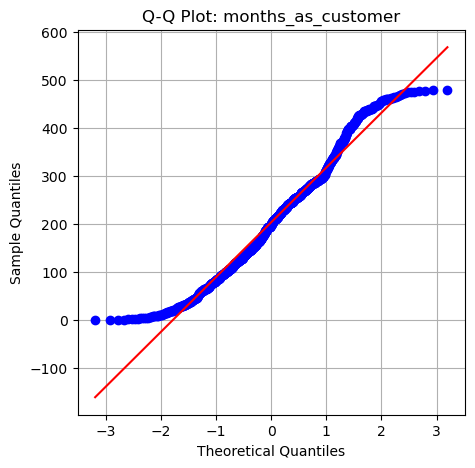

injury_claim — Shapiro-Wilk Test: W = 0.9592, p-value = 0.0000
❌ Likely NOT normal distribution (reject H0)


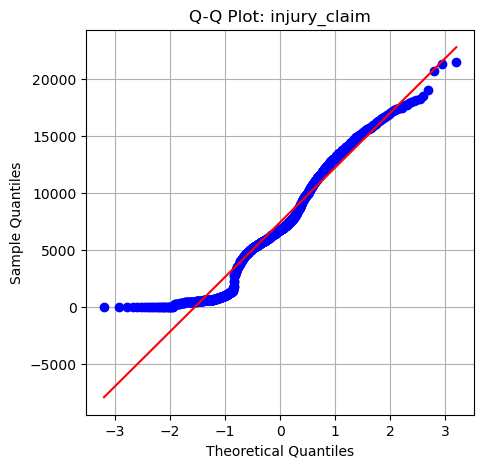

property_claim — Shapiro-Wilk Test: W = 0.9624, p-value = 0.0000
❌ Likely NOT normal distribution (reject H0)


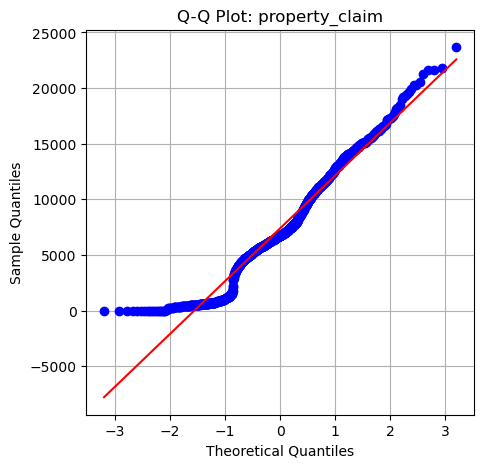

vehicle_claim — Shapiro-Wilk Test: W = 0.9141, p-value = 0.0000
❌ Likely NOT normal distribution (reject H0)


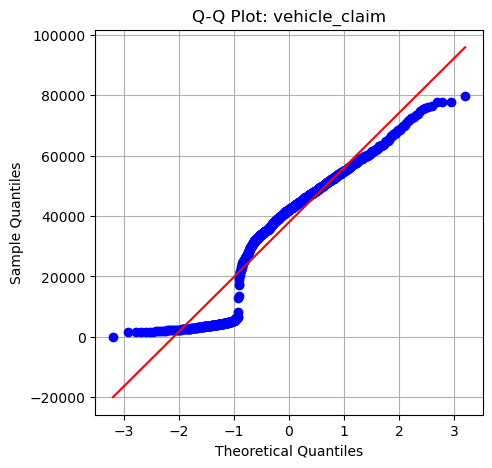

policy_annual_premium — Shapiro-Wilk Test: W = 0.9993, p-value = 0.9793
✅ Likely normal distribution (fail to reject H0)


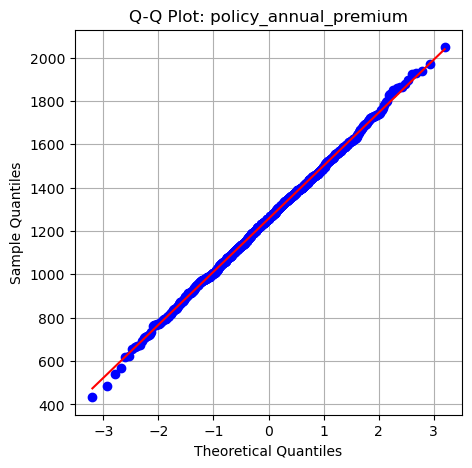

In [1264]:
summary = check_all_columns_normality(df_cleaned)
summary


check Anderson-Darling Test 

In [1265]:
def check_normality_anderson(df):
    """
    ตรวจสอบการแจกแจงแบบปกติของทุกคอลัมน์ตัวเลขใน DataFrame
    โดยใช้ Anderson-Darling Test และ Q-Q Plot
    """
    numeric_cols = df.select_dtypes(include=['int', 'float']).columns

    for col in numeric_cols:
        data = df[col].dropna()
        if len(data) < 5:
            print(f"⚠️ Column '{col}' มีข้อมูลน้อยเกินไปสำหรับการทดสอบ\n")
            continue

        # Anderson-Darling Test
        result = stats.anderson(data, dist='norm')
        print(
            f"📊 Anderson-Darling Test for '{col}': A² = {result.statistic:.4f}")
        print("Critical values (sig level %):")
        for sl, cv in zip(result.significance_level, result.critical_values):
            status = "❌ Reject H0" if result.statistic > cv else "✅ Fail to Reject H0"
            print(f"  - {sl}%: {cv:.4f} → {status}")
        print()

        # Q-Q Plot
        plt.figure(figsize=(5, 5))
        stats.probplot(data, dist="norm", plot=plt)
        plt.title(f"Q-Q Plot: {col}")
        plt.xlabel("Theoretical Quantiles")
        plt.ylabel("Sample Quantiles")
        plt.grid(True)
        plt.show()


📊 Anderson-Darling Test for 'months_as_customer': A² = 4.7455
Critical values (sig level %):
  - 15.0%: 0.5740 → ❌ Reject H0
  - 10.0%: 0.6530 → ❌ Reject H0
  - 5.0%: 0.7840 → ❌ Reject H0
  - 2.5%: 0.9140 → ❌ Reject H0
  - 1.0%: 1.0880 → ❌ Reject H0



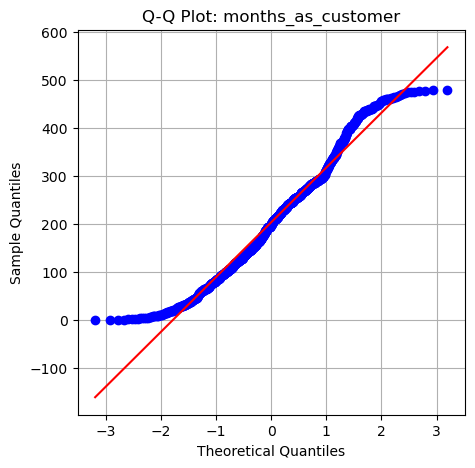

📊 Anderson-Darling Test for 'injury_claim': A² = 10.6602
Critical values (sig level %):
  - 15.0%: 0.5740 → ❌ Reject H0
  - 10.0%: 0.6530 → ❌ Reject H0
  - 5.0%: 0.7840 → ❌ Reject H0
  - 2.5%: 0.9140 → ❌ Reject H0
  - 1.0%: 1.0880 → ❌ Reject H0



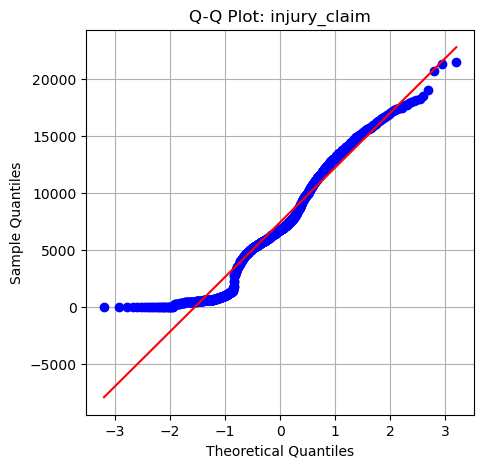

📊 Anderson-Darling Test for 'property_claim': A² = 9.5739
Critical values (sig level %):
  - 15.0%: 0.5740 → ❌ Reject H0
  - 10.0%: 0.6530 → ❌ Reject H0
  - 5.0%: 0.7840 → ❌ Reject H0
  - 2.5%: 0.9140 → ❌ Reject H0
  - 1.0%: 1.0880 → ❌ Reject H0



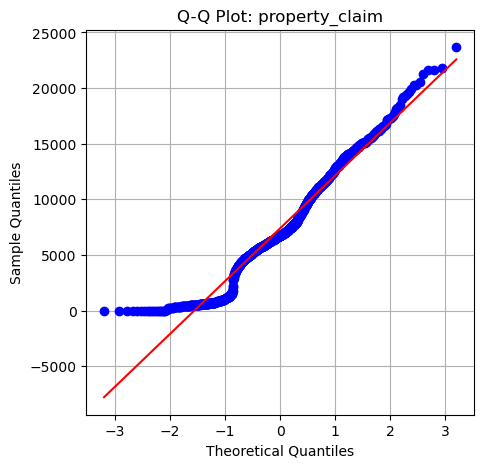

📊 Anderson-Darling Test for 'vehicle_claim': A² = 32.2880
Critical values (sig level %):
  - 15.0%: 0.5740 → ❌ Reject H0
  - 10.0%: 0.6530 → ❌ Reject H0
  - 5.0%: 0.7840 → ❌ Reject H0
  - 2.5%: 0.9140 → ❌ Reject H0
  - 1.0%: 1.0880 → ❌ Reject H0



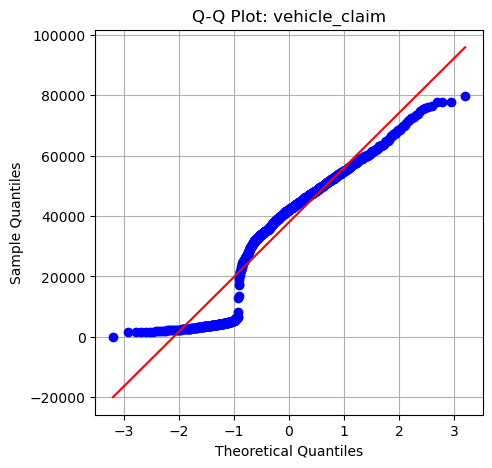

📊 Anderson-Darling Test for 'policy_annual_premium': A² = 0.1695
Critical values (sig level %):
  - 15.0%: 0.5740 → ✅ Fail to Reject H0
  - 10.0%: 0.6530 → ✅ Fail to Reject H0
  - 5.0%: 0.7840 → ✅ Fail to Reject H0
  - 2.5%: 0.9140 → ✅ Fail to Reject H0
  - 1.0%: 1.0880 → ✅ Fail to Reject H0



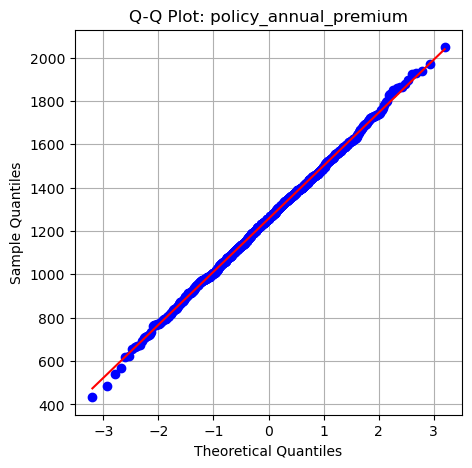

In [1266]:
summary = check_normality_anderson(df_cleaned)
summary


แก้

In [1267]:
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer


In [1268]:
def normalize_column(df, column, method='yeo-johnson'):
    """
    แปลงคอลัมน์ให้เข้าใกล้ normal distribution
    method: 'log', 'sqrt', 'boxcox', 'yeo-johnson'
    คืนค่า: Series ใหม่ที่แปลงแล้ว
    """
    data = df[column].dropna()

    if method == 'log':
        if (data < 0).any():
            raise ValueError("Log ใช้กับค่าบวกเท่านั้น")
        return np.log1p(df[column])  # log(x + 1)

    elif method == 'sqrt':
        if (data < 0).any():
            raise ValueError("Sqrt ใช้กับค่าบวกเท่านั้น")
        return np.sqrt(df[column])

    elif method == 'boxcox':
        if (data <= 0).any():
            raise ValueError("Box-Cox ใช้ได้กับค่ามากกว่า 0 เท่านั้น")
        transformed, _ = boxcox(data)
        df_result = df[column].copy()
        df_result.loc[data.index] = transformed
        return df_result

    elif method == 'yeo-johnson':
        pt = PowerTransformer(method='yeo-johnson')
        reshaped = df[[column]].copy()
        reshaped[column] = reshaped[column].fillna(0)  # หรือกำหนดเอง
        transformed = pt.fit_transform(reshaped)
        return pd.Series(transformed.flatten(), index=df.index, name=column + '_transformed')

    else:
        raise ValueError(f"ไม่รู้จัก method '{method}' — ใช้ได้: 'log', 'sqrt', 'boxcox', 'yeo-johnson'")


In [1280]:
df_cleaned_normalize = df_cleaned.copy()


In [1281]:
# ตัวอย่าง: แปลง 'months_as_customer' ด้วย Yeo-Johnson

df_cleaned_normalize['months_as_customer'] = normalize_column(df_cleaned_normalize, 'months_as_customer', method='sqrt')
df_cleaned_normalize['vehicle_claim'] = normalize_column(
    df_cleaned_normalize, 'vehicle_claim', method='yeo-johnson')
df_cleaned_normalize['property_claim'] = normalize_column(
    df_cleaned_normalize, 'property_claim', method='yeo-johnson')


months_as_customer — Shapiro-Wilk Test: W = 0.9804, p-value = 0.0000
❌ Likely NOT normal distribution (reject H0)


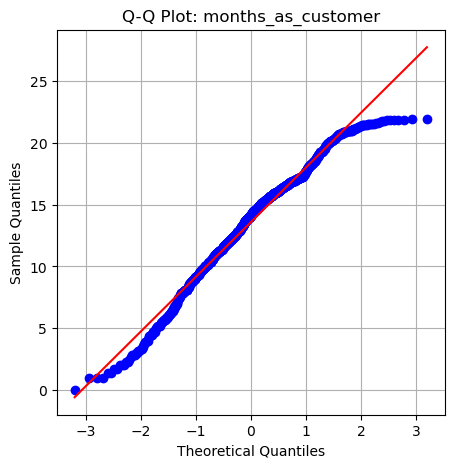

injury_claim — Shapiro-Wilk Test: W = 0.9592, p-value = 0.0000
❌ Likely NOT normal distribution (reject H0)


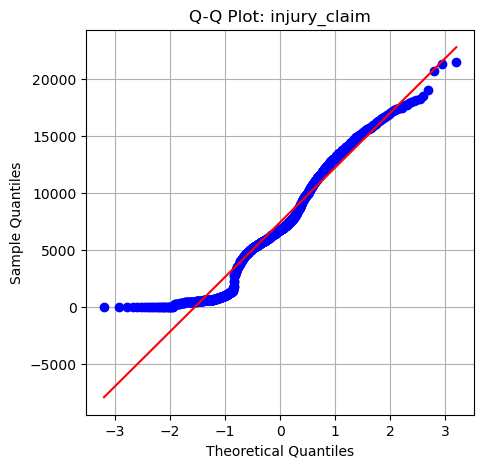

property_claim — Shapiro-Wilk Test: W = 0.9601, p-value = 0.0000
❌ Likely NOT normal distribution (reject H0)


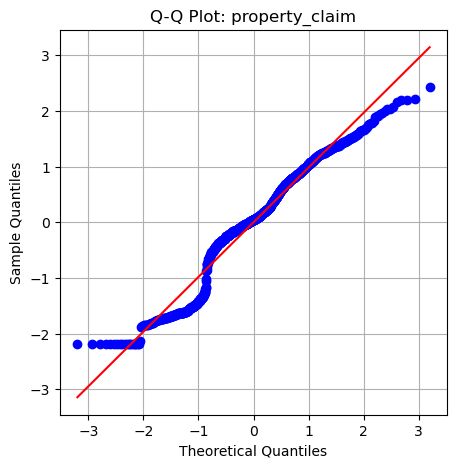

vehicle_claim — Shapiro-Wilk Test: W = 0.9254, p-value = 0.0000
❌ Likely NOT normal distribution (reject H0)


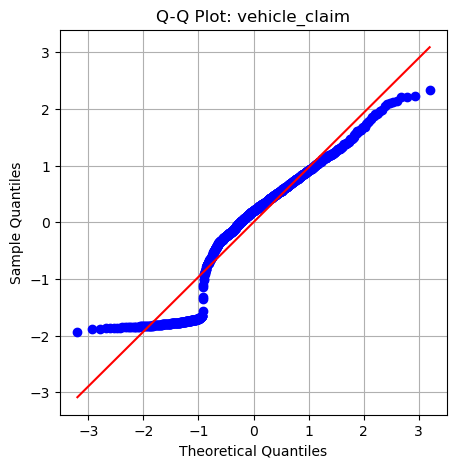

policy_annual_premium — Shapiro-Wilk Test: W = 0.9993, p-value = 0.9793
✅ Likely normal distribution (fail to reject H0)


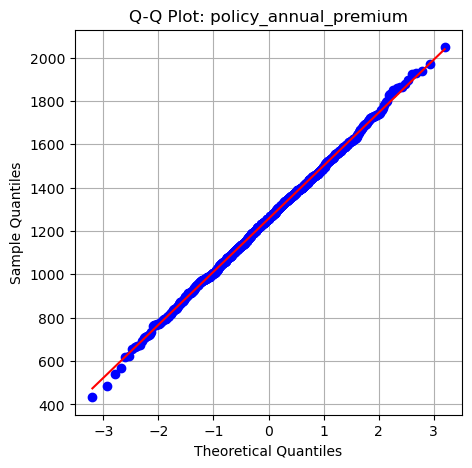

In [1282]:
summary = check_all_columns_normality(df_cleaned_normalize)
summary


## check Non-singularity 

In [ ]:

def check_determinant(df):
    cov = np.cov(df.T)
    det = np.linalg.det(cov)
    if np.isclose(det, 0.0):
        print("❌ Covariance matrix is **singular** (determinant ≈ 0)")
    else:
        print(
            f"✅ Covariance matrix is **non-singular** (determinant = {det:.6f})")
    return det


In [ ]:
summary = check_determinant(df_cleaned)
summary


✅ Covariance matrix is **non-singular** (determinant = 34131782160115896809476467982336.000000)


3.4131782160115897e+31

# Model 

## model robust mahalanobis anomaly

In [ ]:
from sklearn.covariance import MinCovDet
from sklearn.preprocessing import StandardScaler


In [ ]:
def robust_mahalanobis_anomaly(X_input, threshold_percentile=0.8, return_distance=False, random_state=42):
    """
    Robust Mahalanobis Distance anomaly detection (Z-score scaling done inside)

    Parameters:
    - X_input: pandas DataFrame (raw scale)
    - threshold_percentile: float, percentile cutoff (default=0.975)
    - return_distance: if True, return also the threshold
    - random_state: int, for reproducibility

    Returns:
    - result_df: DataFrame (original scale) + mahalanobis_distance + anomaly
    """
    if not isinstance(X_input, pd.DataFrame):
        raise ValueError("X_input must be a pandas DataFrame")

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_input)

    # ✅ Fix randomness
    mcd = MinCovDet(random_state=random_state).fit(X_scaled)
    distances = mcd.mahalanobis(X_scaled)

    threshold = np.percentile(distances, threshold_percentile * 100)
    anomalies = (distances > threshold).astype(int)

    result_df = X_input.copy()
    result_df["mahalanobis_distance"] = distances
    result_df["anomaly"] = anomalies

    if return_distance:
        return result_df, threshold
    else:
        return result_df




In [ ]:
result_df = robust_mahalanobis_anomaly(df_cleaned, threshold_percentile=0.6)
result_df


,months_as_customer,injury_claim,property_claim,vehicle_claim,policy_annual_premium,mahalanobis_distance,anomaly
0,328,6510,13020,52080,1406.91,781.621487,1
1,228,780,780,3510,1197.22,1.874284,0
2,134,7700,3850,23100,1413.14,274.102841,0
3,256,6340,6340,50720,1415.74,2.916480,0
4,228,1300,650,4550,1583.91,11.421065,0
...,...,...,...,...,...,...,...
995,3,17440,8720,61040,1310.80,1410.113298,1
996,285,18080,18080,72320,1436.79,7.097462,0
997,130,7500,7500,52500,1383.49,2.375512,0
998,458,5220,5220,36540,1356.92,6.034871,0


## p-value

In [ ]:
from scipy.stats import chi2


In [ ]:
from scipy.stats import chi2

def add_pvalue_to_result(result_df, alpha=0.05):
    """
    เพิ่ม p-value และ anomaly_pvalue โดยไม่ต้องระบุ n_features
    จะตรวจหา df อัตโนมัติจากคอลัมน์ใน result_df

    Parameters:
        result_df: DataFrame ที่ได้จาก robust_mahalanobis_anomaly()
        alpha: ค่าความเชื่อมั่น (default = 0.05)

    Returns:
        result_df: DataFrame เดิมที่เพิ่ม 'p_value' และ 'anomaly_pvalue'
    """
    if "mahalanobis_distance" not in result_df.columns:
        raise ValueError("Column 'mahalanobis_distance' not found in input DataFrame.")

    # คำนวณ d^2
    d_squared = result_df["mahalanobis_distance"] ** 2

    # หา feature columns = all - known outputs
    ignore_cols = {"mahalanobis_distance", "anomaly", "p_value", "anomaly_pvalue"}
    feature_cols = [col for col in result_df.columns if col not in ignore_cols]
    df = len(feature_cols)

    # คำนวณ p-value และ anomaly จาก cutoff
    p_values = 1 - chi2.cdf(d_squared, df=df)
    result_df["p_value"] = p_values
    result_df["anomaly_pvalue"] = (p_values < alpha).astype(int)

    return result_df




In [ ]:
result_df = add_pvalue_to_result(result_df, alpha=0.01)
result_df


,months_as_customer,injury_claim,property_claim,vehicle_claim,policy_annual_premium,mahalanobis_distance,anomaly,p_value,anomaly_pvalue
0,328,6510,13020,52080,1406.91,781.621487,1,0.000000e+00,1
1,228,780,780,3510,1197.22,1.874284,0,6.214306e-01,0
2,134,7700,3850,23100,1413.14,274.102841,0,0.000000e+00,1
3,256,6340,6340,50720,1415.74,2.916480,0,1.304728e-01,0
4,228,1300,650,4550,1583.91,11.421065,0,0.000000e+00,1
...,...,...,...,...,...,...,...,...,...
995,3,17440,8720,61040,1310.80,1410.113298,1,0.000000e+00,1
996,285,18080,18080,72320,1436.79,7.097462,0,1.161870e-09,1
997,130,7500,7500,52500,1383.49,2.375512,0,3.425142e-01,0
998,458,5220,5220,36540,1356.92,6.034871,0,7.828040e-07,1


In [ ]:
from sklearn.decomposition import PCA

In [ ]:
def plot_pca_anomaly(result_df, anomaly_col='anomaly'):
    """
    สร้างกราฟ PCA 2D โดยเลือกฟีเจอร์หลัก และระบุคอลัมน์ที่ใช้แบ่งกลุ่ม anomaly
    Parameters:
        result_df (pd.DataFrame): ข้อมูลที่มี features และคอลัมน์ anomaly
        anomaly_col (str): ชื่อคอลัมน์ที่ใช้แบ่งสี (default = 'anomaly')
    """
    # เลือกฟีเจอร์สำหรับ PCA
    feature_cols = [
        'months_as_customer',
        'injury_claim', 'property_claim', 'vehicle_claim',
        'policy_annual_premium'
    ]

    # ตรวจสอบคอลัมน์
    missing = [col for col in feature_cols + [anomaly_col] if col not in result_df.columns]
    if missing:
        raise ValueError(f"Missing columns in result_df: {missing}")

    # เตรียมข้อมูล
    X = result_df[feature_cols]
    y = result_df[anomaly_col]

    # สเกลข้อมูล
    X_scaled = StandardScaler().fit_transform(X)

    # ทำ PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # รวมเป็น DataFrame สำหรับ plot
    pca_df = pd.DataFrame({
        'PC1': X_pca[:, 0],
        'PC2': X_pca[:, 1],
        'anomaly': y
    })

    # Plot
    plt.figure(figsize=(8, 6))
    unique_labels = sorted(pca_df['anomaly'].unique())
    colors = plt.cm.Set1.colors  # ใช้ color map

    for i, val in enumerate(unique_labels):
        subset = pca_df[pca_df['anomaly'] == val]
        plt.scatter(subset['PC1'], subset['PC2'],
                    c=[colors[i % len(colors)]], label=str(val), alpha=0.6, edgecolor='k')

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(f'PCA - Colored by {anomaly_col}')
    plt.legend(title=anomaly_col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## eda model

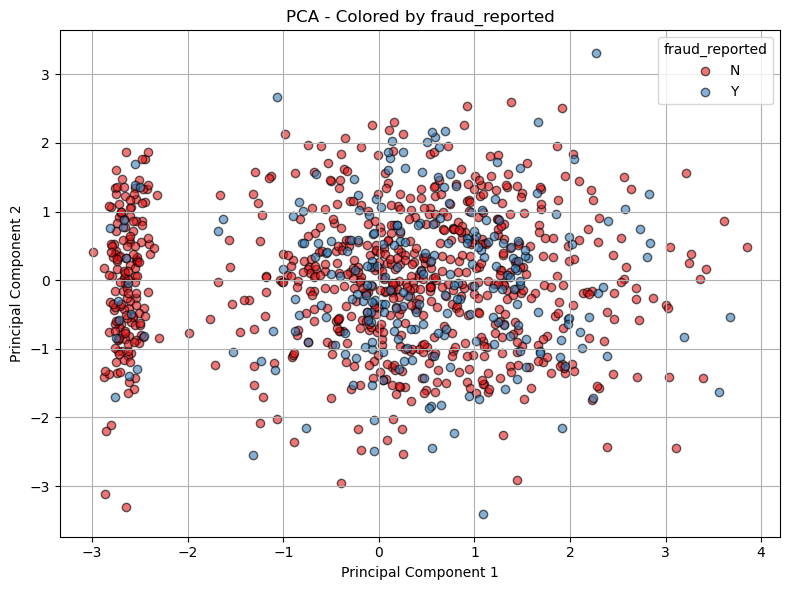

In [ ]:
plot_pca_anomaly(df,anomaly_col='fraud_reported')

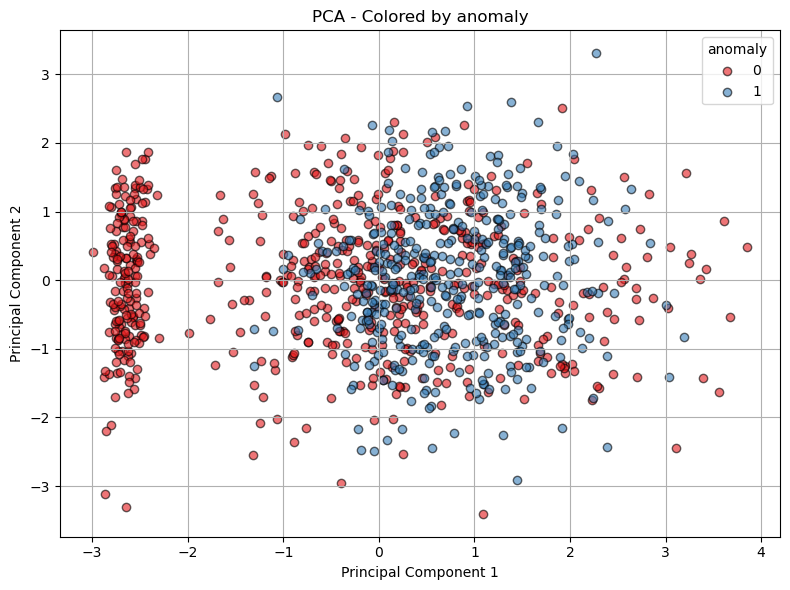

In [ ]:
plot_pca_anomaly(result_df,anomaly_col='anomaly')

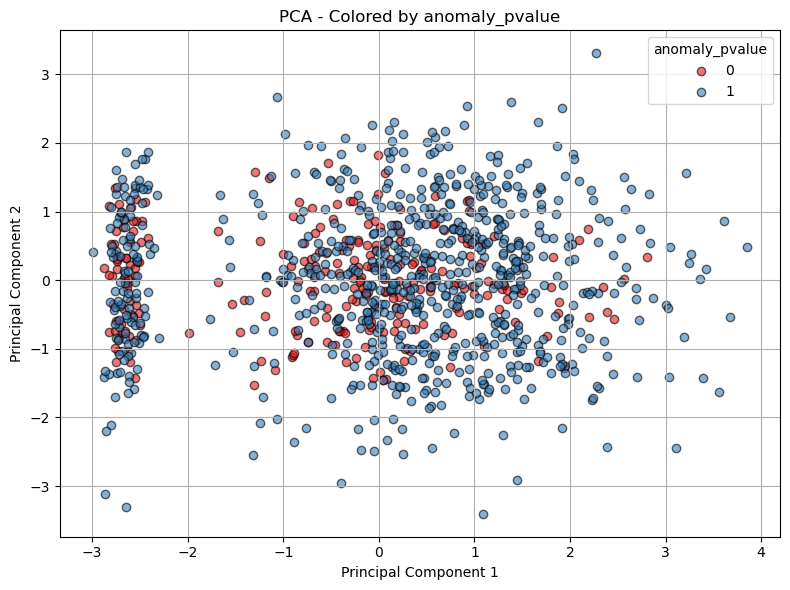

In [ ]:
plot_pca_anomaly(result_df,anomaly_col='anomaly_pvalue')

# Quantify Model

## quantify model

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, fbeta_score
import pandas as pd


In [ ]:
def convert_fraud_column(df, column='fraud_reported'):
    """
    แปลงค่าคอลัมน์ 'fraud_reported' จาก 'Y' → 1 และ 'N' → 0
    Parameters:
        df (pd.DataFrame): DataFrame ที่ต้องการแปลง
        column (str): ชื่อคอลัมน์ที่ต้องการแปลง
    Returns:
        pd.DataFrame: DataFrame ที่มีการแปลงค่าคอลัมน์เรียบร้อยแล้ว
    """
    df = df.copy()
    df["fraud_reported"] = df["fraud_reported"].map({'Y': 1, 'N': 0})
    return df


In [ ]:
df = convert_fraud_column(df)
df

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17 00:00:00,OH,250/500,1000,1406.91,0,466132,...,2,YES,71610,6510,13020,52080,Saab,92x,2004,1
1,228,42,342868,2006-06-27 00:00:00,IN,250/500,2000,1197.22,5000000,468176,...,0,?,5070,780,780,3510,Mercedes,E400,2007,1
2,134,29,687698,2000-09-06 00:00:00,OH,100/300,2000,1413.14,5000000,430632,...,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,0
3,256,41,227811,1990-05-25 00:00:00,IL,250/500,2000,1415.74,6000000,608117,...,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,1
4,228,44,367455,2014-06-06 00:00:00,IL,500/1000,1000,1583.91,6000000,610706,...,1,NO,6500,1300,650,4550,Accura,RSX,2009,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16 00:00:00,OH,500/1000,1000,1310.8,0,431289,...,1,?,87200,17440,8720,61040,Honda,Accord,2006,0
996,285,41,186934,2014-01-05 00:00:00,IL,100/300,1000,1436.79,0,608177,...,3,?,108480,18080,18080,72320,Volkswagen,Passat,2015,0
997,130,34,918516,2003-02-17 00:00:00,OH,250/500,500,1383.49,3000000,442797,...,3,YES,67500,7500,7500,52500,Suburu,Impreza,1996,0
998,458,62,533940,2011-11-18 00:00:00,IL,500/1000,2000,1356.92,5000000,441714,...,1,YES,46980,5220,5220,36540,Audi,A5,1998,0


In [ ]:
def merge_model_results(df, result_df):
    """
    รวมคอลัมน์ผลลัพธ์จาก model (result_df) เข้ากับ df โดย:
    - ใช้ df เป็นหลัก
    - รวมเฉพาะคอลัมน์ที่มีใน result_df และอยู่ในรายการเป้าหมาย
    Parameters:
        df (pd.DataFrame): ข้อมูลต้นฉบับ
        result_df (pd.DataFrame): ข้อมูลผลลัพธ์จาก model
    Returns:
        pd.DataFrame: DataFrame ใหม่ที่รวมผลลัพธ์เฉพาะคอลัมน์ที่ตรง
    """
    target_columns = ['mahalanobis_distance', 'anomaly', 'p_value', 'anomaly_pvalue']
    available_columns = [col for col in target_columns if col in result_df.columns]

    # เช็คว่า row ตรงกันไหม
    if len(df) != len(result_df):
        raise ValueError("จำนวนแถวของ df และ result_df ต้องเท่ากัน")

    # รวมข้อมูล
    df_merged = pd.concat([df.reset_index(drop=True), result_df[available_columns].reset_index(drop=True)], axis=1)
    return df_merged

In [ ]:
df_merged = merge_model_results(df, result_df)
df_merged 

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,mahalanobis_distance,anomaly,p_value,anomaly_pvalue
0,328,48,521585,2014-10-17 00:00:00,OH,250/500,1000,1406.91,0,466132,...,13020,52080,Saab,92x,2004,1,781.621487,1,0.000000e+00,1
1,228,42,342868,2006-06-27 00:00:00,IN,250/500,2000,1197.22,5000000,468176,...,780,3510,Mercedes,E400,2007,1,1.874284,0,6.214306e-01,0
2,134,29,687698,2000-09-06 00:00:00,OH,100/300,2000,1413.14,5000000,430632,...,3850,23100,Dodge,RAM,2007,0,274.102841,0,0.000000e+00,1
3,256,41,227811,1990-05-25 00:00:00,IL,250/500,2000,1415.74,6000000,608117,...,6340,50720,Chevrolet,Tahoe,2014,1,2.916480,0,1.304728e-01,0
4,228,44,367455,2014-06-06 00:00:00,IL,500/1000,1000,1583.91,6000000,610706,...,650,4550,Accura,RSX,2009,0,11.421065,0,0.000000e+00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16 00:00:00,OH,500/1000,1000,1310.8,0,431289,...,8720,61040,Honda,Accord,2006,0,1410.113298,1,0.000000e+00,1
996,285,41,186934,2014-01-05 00:00:00,IL,100/300,1000,1436.79,0,608177,...,18080,72320,Volkswagen,Passat,2015,0,7.097462,0,1.161870e-09,1
997,130,34,918516,2003-02-17 00:00:00,OH,250/500,500,1383.49,3000000,442797,...,7500,52500,Suburu,Impreza,1996,0,2.375512,0,3.425142e-01,0
998,458,62,533940,2011-11-18 00:00:00,IL,500/1000,2000,1356.92,5000000,441714,...,5220,36540,Audi,A5,1998,0,6.034871,0,7.828040e-07,1


In [ ]:
def evaluate_binary_classification(df, y_pred=None, true_col='true', beta_list=[1, 0.5]):
    """
    ประเมินผล classification: precision, recall, f1, f-beta และ confusion matrix

    Parameters:
        df (pd.DataFrame): DataFrame ที่มีค่าจริงใน true_col
        y_pred (array-like): ค่าทำนายภายนอก (optional) ถ้าไม่ใส่ จะใช้ df['pred']
        true_col (str): ชื่อคอลัมน์ค่าจริงใน df
        beta_list (list): beta ต่าง ๆ สำหรับคำนวณ f-beta

    Returns:
        dict: ค่าประเมินทั้งหมด
    """
    y_true = df["fraud_reported"].values
    if y_pred is None:
        if 'pred' not in df.columns:
            raise ValueError("ต้องระบุ y_pred หรือให้ df มีคอลัมน์ชื่อ 'pred'")
        y_pred = df['pred'].values
    else:
        y_pred = pd.Series(y_pred).values

    results = {
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1_score": f1_score(y_true, y_pred, zero_division=0),
        "confusion_matrix": confusion_matrix(y_true, y_pred).tolist()
    }

    for b in beta_list:
        results[f"f{b}_score"] = fbeta_score(y_true, y_pred, beta=b, zero_division=0)

    return results

In [ ]:
quantify = evaluate_binary_classification(df_merged , y_pred=df_merged['anomaly'])
quantify

{'precision': 0.3375,
 'recall': 0.5465587044534413,
 'f1_score': 0.41731066460587324,
 'confusion_matrix': [[488, 265], [112, 135]],
 'f0.5_score': 0.3654574986464537}

In [ ]:
quantify = evaluate_binary_classification(df_merged , y_pred=df_merged['anomaly_pvalue'])
quantify

{'precision': 0.2692828146143437,
 'recall': 0.805668016194332,
 'f1_score': 0.40365111561866124,
 'confusion_matrix': [[213, 540], [48, 199]],
 'f0.5_score': 0.3106462691226975}

## best quantile & alpha

In [ ]:
def evaluate_percentile_alpha_performance_with_best(
    X_input,
    df_true,
    label_col='fraud_reported',
    percentile=np.arange(0.90, 0.991, 0.01),
    alphas=np.arange(0.01, 0.201, 0.025),
    beta=0.5 
):
    if df_true[label_col].dtype == object:
        y_true = df_true[label_col].map({'Y': 1, 'N': 0}).astype(int)
    else:
        y_true = df_true[label_col].astype(int)

    percentile_rows = []
    for q in percentile:
        result_df = robust_mahalanobis_anomaly(X_input, threshold_percentile=q)
        y_pred = result_df['anomaly']
        percentile_rows.append({
            'percentile': round(q, 3),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            f'f{beta}': fbeta_score(y_true, y_pred, beta=beta, zero_division=0),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'anomaly_count': y_pred.sum()
        })

    percentile_df = pd.DataFrame(percentile_rows)
    best_q_row = percentile_df.loc[percentile_df[f'f{beta}'].idxmax()]

    result_df = robust_mahalanobis_anomaly(X_input, threshold_percentile=0.975)
    result_df = add_pvalue_to_result(result_df, alpha=0.05)

    alpha_rows = []
    for alpha in alphas:
        y_pred = (result_df["p_value"] < alpha).astype(int)
        alpha_rows.append({
            'alpha': round(alpha, 3),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            f'f{beta}': fbeta_score(y_true, y_pred, beta=beta, zero_division=0),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'anomaly_count': y_pred.sum()
        })

    alpha_df = pd.DataFrame(alpha_rows)
    best_a_row = alpha_df.loc[alpha_df[f'f{beta}'].idxmax()]

    
    return percentile_df, alpha_df, best_q_row, best_a_row


In [ ]:
percentile_df, alpha_df, best_q, best_a = evaluate_percentile_alpha_performance_with_best(
    X_input=df_cleaned,
    df_true=df,
    label_col='fraud_reported',
    percentile=np.arange(1, 0.49, -0.025),
    alphas=np.arange(0.01, 0.201, 0.025),
    beta=0.5
)

In [ ]:
percentile_df

,percentile,precision,recall,f0.5,f1,anomaly_count
0,1.000,0.000000,0.000000,0.000000,0.000000,0
1,0.975,0.480000,0.048583,0.172911,0.088235,25
2,0.950,0.400000,0.080972,0.223714,0.134680,50
3,0.925,0.386667,0.117409,0.265082,0.180124,75
4,0.900,0.390000,0.157895,0.301391,0.224784,100
5,0.875,0.360000,0.182186,0.301205,0.241935,125
6,0.850,0.366667,0.222672,0.324675,0.277078,150
7,0.825,0.365714,0.259109,0.337909,0.303318,175
8,0.800,0.380000,0.307692,0.362942,0.340045,200
9,0.775,0.351111,0.319838,0.344377,0.334746,225


In [ ]:
alpha_df

,alpha,precision,recall,f0.5,f1,anomaly_count
0,0.010,0.269283,0.805668,0.310646,0.403651,739
1,0.035,0.264323,0.821862,0.305815,0.400000,768
2,0.060,0.263694,0.838057,0.305580,0.401163,785
3,0.085,0.260979,0.842105,0.302766,0.398467,797
4,0.110,0.259305,0.846154,0.301066,0.396961,806
5,0.135,0.257985,0.850202,0.299743,0.395853,814
6,0.160,0.257908,0.858300,0.299859,0.396632,822
7,0.185,0.256010,0.862348,0.297902,0.394810,832


In [ ]:
best_q

percentile         0.600000
precision          0.337500
recall             0.546559
f0.5               0.365457
f1                 0.417311
anomaly_count    400.000000
Name: 16, dtype: float64

In [ ]:
best_a

alpha              0.010000
precision          0.269283
recall             0.805668
f0.5               0.310646
f1                 0.403651
anomaly_count    739.000000
Name: 0, dtype: float64

# 1,0

## convert to 0,1

In [ ]:
def binarize_high_percentile(df, percentile_threshold=0.975):
    """
    แปลงค่าทุก column ให้เป็น 1 ถ้าเกิน percentile ที่กำหนด, อื่น ๆ เป็น 0

    Parameters:
        df (pd.DataFrame): DataFrame ที่มีแต่ค่าตัวเลข
        percentile_threshold (float): ค่าที่ใช้ตัด (default = 0.975)

    Returns:
        pd.DataFrame: DataFrame ที่แปลงเป็น binary แล้ว (1 ถ้าเกิน percentile, 0 ถ้าไม่เกิน)
    """
    binary_df = df.copy()
    for col in binary_df.columns:
        threshold = np.percentile(binary_df[col], percentile_threshold * 100)
        binary_df[col] = (binary_df[col] > threshold).astype(int)
    return binary_df


In [ ]:
binary_df = binarize_high_percentile(df_cleaned, percentile_threshold=0.95)
binary_df

,months_as_customer,injury_claim,property_claim,vehicle_claim,policy_annual_premium
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
995,0,1,0,0,0
996,0,1,1,1,0
997,0,0,0,0,0
998,1,0,0,0,0


## model no sacler

In [ ]:


def robust_mahalanobis_anomaly_noscaler(X_input, threshold_percentile=0.8, return_distance=False, random_state=42):
    """
    Robust Mahalanobis Distance anomaly detection (ไม่ทำ Standardization)

    Parameters:
    - X_input: pandas DataFrame (raw scale, ไม่ทำ scaling)
    - threshold_percentile: float, percentile cutoff (default=0.8)
    - return_distance: if True, return also the threshold
    - random_state: int, for reproducibility

    Returns:
    - result_df: DataFrame (original scale) + mahalanobis_distance + anomaly
    """
    if not isinstance(X_input, pd.DataFrame):
        raise ValueError("X_input must be a pandas DataFrame")

    # ✅ ไม่ทำ StandardScaler
    mcd = MinCovDet(random_state=random_state).fit(X_input)
    distances = mcd.mahalanobis(X_input)

    threshold = np.percentile(distances, threshold_percentile *100)
    anomalies = (distances > threshold).astype(int)

    result_df = X_input.copy()
    result_df["mahalanobis_distance"] = distances
    result_df["anomaly"] = anomalies

    if return_distance:
        return result_df, threshold
    else:
        return result_df



In [ ]:
# result_df = robust_mahalanobis_anomaly_noscaler(binary_df, threshold_percentile=0.9)
# result_df

In [ ]:
# result_df = add_pvalue_to_result(result_df, alpha=0.01)
# result_df

In [ ]:
# result_df['anomaly'].value_counts()

In [ ]:
# result_df['anomaly_pvalue'].value_counts()

In [ ]:
# # Final function to run
# def evaluate_percentile_alpha_performance_with_best10(
#     X_input,
#     df_true,
#     label_col='fraud_reported',
#     percentiles=np.arange(0.90, 0.991, 0.01),
#     alphas=np.arange(0.01, 0.201, 0.025),
#     beta=0.5 
# ):
#     if df_true[label_col].dtype == object:
#         y_true = df_true[label_col].map({'Y': 1, 'N': 0}).astype(int)
#     else:
#         y_true = df_true[label_col].astype(int)

#     percentile_rows = []
#     for q in percentiles:
#         result_df = robust_mahalanobis_anomaly_noscaler(X_input, threshold_percentile=q)
#         y_pred = result_df['anomaly']
#         percentile_rows.append({
#             'percentile': round(q, 3),
#             'precision': precision_score(y_true, y_pred, zero_division=0),
#             'recall': recall_score(y_true, y_pred, zero_division=0),
#             f'f{beta}': fbeta_score(y_true, y_pred, beta=beta, zero_division=0),
#             'f1': f1_score(y_true, y_pred, zero_division=0)
#         })
        
#     percentile_df = pd.DataFrame(percentile_rows)
#     best_q_row = percentile_df.loc[percentile_df[f'f{beta}'].idxmax()]

#     result_df = robust_mahalanobis_anomaly_noscaler(X_input, threshold_percentile=0.975)
#     result_df = add_pvalue_to_result(result_df, alpha=0.05)

#     alpha_rows = []
#     for alpha in alphas:
#         y_pred = (result_df["p_value"] < alpha).astype(int)
#         alpha_rows.append({
#             'alpha': round(alpha, 3),
#             'precision': precision_score(y_true, y_pred, zero_division=0),
#             'recall': recall_score(y_true, y_pred, zero_division=0),
#             f'f{beta}': fbeta_score(y_true, y_pred, beta=beta, zero_division=0),
#             'f1': f1_score(y_true, y_pred, zero_division=0)
#         })

#     alpha_df = pd.DataFrame(alpha_rows)
#     best_a_row = alpha_df.loc[alpha_df[f'f{beta}'].idxmax()]

#     return percentile_df, alpha_df, best_q_row, best_a_row


In [ ]:
# percentiledf, alpha_df, best_q, best_a = evaluate_percentile_alpha_performance_with_best10(
#     X_input=binary_df,
#     df_true=df,
#     label_col='fraud_reported',
#     percentile=np.arange(1, 0.69, -0.025),
#     alphas=np.arange(0.00, 0.201, 0.025),
#     beta=0.5
# )

In [ ]:
# percentile_df


In [ ]:
# alpha_df

In [ ]:
# import matplotlib.pyplot as plt
# plt.hist(result_df["mahalanobis_distance"], bins=50)
# plt.title("Histogram of Mahalanobis Distance")
# plt.show()
